In [15]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
from typing import List

from config import BASE_DIR
print(os.getcwd()+' -> ',end=' ')
os.chdir(BASE_DIR)
print(BASE_DIR)

from scripts.indicators import find_pivots,donchian

C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www ->  C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [16]:
#klines_file =  './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/2d01/Lateral_BTCUSDT_2d01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
klines_file = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'


with open(klines_file, 'rb') as file:
    df = pickle.load(file)


In [17]:
class Order:
    datetime = None
    side = ''
    qty = 0
    price = 0

    def __init__(self,datetime,side,qty,price):
        self.datetime = datetime
        self.side = side
        self.qty = qty
        self.price = price
    
    def __repr__(self):
        return '<' + str(self) + '>'

    def __str__(self):
        params = f'{self.datetime} {self.side}\t{self.qty:.8f}\t{self.price:.8f}'
        return f'{self.__class__.__name__} {params}'

class Strategy:

    data = pd.DataFrame
    start_at = 0
    cash = 0
    qty = 0
    pos = False
    orders = {}



    def __init__(self,cash,data,start_at):
        self.start_at = start_at
        self.data = data
        self.cash = cash
        #Aplica las señales de compra venta a la totalidad del dataframe
        self.signal()

        

        #Limita el dataframe a la fecha de inicio real
        self.data.drop(index=df.index[:self.start_at], inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        qty_to_hold = self.cash/float(self.data['close'].loc[0])
        print('qty_to_hold: ',qty_to_hold)
        self.data['hold'] = self.data['close'] * qty_to_hold
        self.data['equity'] = self.data.apply(self.next, axis=1)

       
    def signal(self):
        
        # Pivots
        self.data['ma'] = self.data['close'].rolling(window=21).mean()
        
        #self.data = find_pivots(self.data, dev_threshold = 3.0)
        
        self.data['compra'] = (self.data['close'] < self.data['ma']) #& (self.data['min_pivot'] > 0)
        self.data['venta']  = (self.data['close'] > self.data['ma']) #& (self.data['max_pivot'] > 0)

        self.data['signal'] = np.where(self.data['compra'], 'COMPRA', 'NEUTRO')
        self.data['signal'] = np.where(self.data['venta'], 'VENTA',self.data['signal'])

        self.data.drop('ma', axis=1, inplace=True)
        self.data.drop('compra', axis=1, inplace=True)
        self.data.drop('venta', axis=1, inplace=True)
        #self.data.drop('min_pivot', axis=1, inplace=True)
        #self.data.drop('max_pivot', axis=1, inplace=True)
        print(len(self.data),end="\n\n")

    def next(self,row):
        price = row['close']
        if row['signal'] == 'COMPRA':
            if self.cash > 20 and not self.pos: 
                self.pos = True
                qty = self.cash/price
                self.qty += qty
                self.cash = 0
                order = Order(row['datetime'],'BUY',qty,price)
                self.orders[row.name] = order 
        if row['signal'] == 'VENTA':
            if self.qty >= 0 and self.pos: 
                self.pos = False
                qty = self.qty
                self.qty -= qty
                self.cash += qty * price 
                order = Order(row['datetime'],'SELL',-qty,price)
                self.orders[row.name] = order 
       
        return (self.cash + self.qty*price)
        
    


1356847

qty_to_hold:  1.2155415221937362


<Axes: >

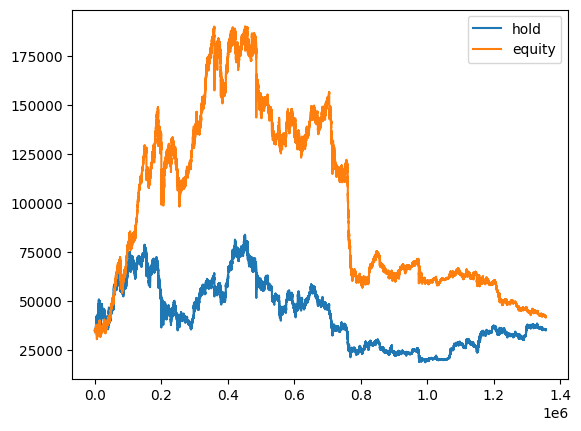

In [18]:

# Aplicar la función signal
bt = Strategy(cash = 35190, data = df, start_at = 211)
bt.data[['hold','equity']].plot()




In [19]:
bt.orders





{0: <Order 2020-12-31 03:31:00 BUY	1.21554152	28950.06000000>,
 1: <Order 2020-12-31 03:32:00 SELL	-1.21554152	28987.66000000>,
 12: <Order 2020-12-31 03:43:00 BUY	1.21571221	28983.59000000>,
 13: <Order 2020-12-31 03:44:00 SELL	-1.21571221	29003.99000000>,
 16: <Order 2020-12-31 03:47:00 BUY	1.21646800	28985.97000000>,
 31: <Order 2020-12-31 04:02:00 SELL	-1.21646800	28962.73000000>,
 32: <Order 2020-12-31 04:03:00 BUY	1.21703570	28949.22000000>,
 33: <Order 2020-12-31 04:04:00 SELL	-1.21703570	28958.14000000>,
 57: <Order 2020-12-31 04:28:00 BUY	1.20882468	29154.84000000>,
 58: <Order 2020-12-31 04:29:00 SELL	-1.20882468	29179.40000000>,
 61: <Order 2020-12-31 04:32:00 BUY	1.21120397	29122.08000000>,
 65: <Order 2020-12-31 04:36:00 SELL	-1.21120397	29195.85000000>,
 66: <Order 2020-12-31 04:37:00 BUY	1.21315859	29148.81000000>,
 76: <Order 2020-12-31 04:47:00 SELL	-1.21315859	29164.25000000>,
 78: <Order 2020-12-31 04:49:00 BUY	1.21375206	29149.99000000>,
 79: <Order 2020-12-31 04:50

In [20]:
from datetime import datetime as dt
print(dt.now())
agg_funcs = {
                "open": "first",
                "high": "max",
                "low": "min",
                "close": "last",
                "volume": "sum",
            }   
new_df = df[['datetime','open','high','low','close','volume']].resample('1D', on="datetime").agg(agg_funcs).reset_index()
print(dt.now())
ohlc = new_df[['datetime','open','high','low','close','volume']].rename(columns={'datetime': 'dt', 'open': 'o', 'high': 'h', 'low': 'l', 'close': 'c', 'volume': 'v'}).to_dict(orient='records')
print(dt.now())
print(df.tail())
ohlc

2023-12-24 09:30:55.017182
2023-12-24 09:30:55.199786
2023-12-24 09:30:55.203777
                   datetime      open      high       low     close    volume  \
1356631 2023-07-31 23:55:00  28948.73  28949.63  28939.86  28945.99  44.27773   
1356632 2023-07-31 23:56:00  28946.00  28946.00  28937.75  28942.45  38.19763   
1356633 2023-07-31 23:57:00  28942.45  28943.55  28936.16  28940.67  74.21980   
1356634 2023-07-31 23:58:00  28940.67  28940.67  28933.22  28933.23  42.51707   
1356635 2023-07-31 23:59:00  28933.22  28933.23  28928.22  28933.22  21.31314   

         signal          hold        equity  
1356631  COMPRA  35185.052746  41850.168281  
1356632  COMPRA  35180.749729  41845.050142  
1356633  COMPRA  35178.586065  41842.476614  
1356634  COMPRA  35169.542436  41831.719848  
1356635  COMPRA  35169.530281  41831.705390  


[{'dt': Timestamp('2020-12-31 00:00:00'),
  'o': 28922.13,
  'h': 29470.0,
  'l': 27850.0,
  'c': 29194.65,
  'v': 62451.731132},
 {'dt': Timestamp('2021-01-01 00:00:00'),
  'o': 29195.25,
  'h': 29600.0,
  'l': 28624.57,
  'c': 29323.82,
  'v': 50318.8003},
 {'dt': Timestamp('2021-01-02 00:00:00'),
  'o': 29323.82,
  'h': 33300.0,
  'l': 29220.0,
  'c': 32741.67,
  'v': 132523.310704},
 {'dt': Timestamp('2021-01-03 00:00:00'),
  'o': 32741.68,
  'h': 34778.11,
  'l': 32267.0,
  'c': 33454.22,
  'v': 123555.724129},
 {'dt': Timestamp('2021-01-04 00:00:00'),
  'o': 33454.21,
  'h': 33600.0,
  'l': 28130.0,
  'c': 32306.64,
  'v': 144655.338308},
 {'dt': Timestamp('2021-01-05 00:00:00'),
  'o': 32306.64,
  'h': 34360.0,
  'l': 29900.0,
  'c': 33873.3,
  'v': 113528.228768},
 {'dt': Timestamp('2021-01-06 00:00:00'),
  'o': 33873.3,
  'h': 37287.63,
  'l': 33357.9,
  'c': 36962.37,
  'v': 129457.535193},
 {'dt': Timestamp('2021-01-07 00:00:00'),
  'o': 36962.37,
  'h': 40365.0,
  'l': 3630

In [21]:
new_df = df[['datetime','signal','low','high']]
sB = df[df['signal']=='COMPRA'][['datetime','low']].rename(columns={'low':'sB'}).to_dict(orient='records')
#new_df['sS'] = new_df[new_df['signal']=='VENTA']['high']
sS= df[df['signal']=='VENTA'][['datetime','high']].rename(columns={'high':'sS'}).to_dict(orient='records')
events = sB+sS
events

[{'datetime': Timestamp('2020-12-31 03:31:00'), 'sB': 28916.94},
 {'datetime': Timestamp('2020-12-31 03:43:00'), 'sB': 28980.44},
 {'datetime': Timestamp('2020-12-31 03:47:00'), 'sB': 28975.59},
 {'datetime': Timestamp('2020-12-31 03:48:00'), 'sB': 28960.0},
 {'datetime': Timestamp('2020-12-31 03:49:00'), 'sB': 28954.66},
 {'datetime': Timestamp('2020-12-31 03:50:00'), 'sB': 28938.8},
 {'datetime': Timestamp('2020-12-31 03:51:00'), 'sB': 28965.72},
 {'datetime': Timestamp('2020-12-31 03:52:00'), 'sB': 28960.01},
 {'datetime': Timestamp('2020-12-31 03:53:00'), 'sB': 28959.05},
 {'datetime': Timestamp('2020-12-31 03:54:00'), 'sB': 28945.5},
 {'datetime': Timestamp('2020-12-31 03:55:00'), 'sB': 28923.41},
 {'datetime': Timestamp('2020-12-31 03:56:00'), 'sB': 28926.61},
 {'datetime': Timestamp('2020-12-31 03:57:00'), 'sB': 28910.0},
 {'datetime': Timestamp('2020-12-31 03:58:00'), 'sB': 28904.54},
 {'datetime': Timestamp('2020-12-31 03:59:00'), 'sB': 28849.5},
 {'datetime': Timestamp('2020-